In [66]:
import torch.optim as optim
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import random
from scipy.special import expit
import sys
import os
import json
from collections import Counter
import re
import pickle
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [50]:
SRC_DIR = "/scratch/gpuligu/MLDS_hw2_1_data"

In [51]:
def data_preprocess():
    with open(os.path.join(SRC_DIR, 'training_label.json'), 'r') as f:
        data = json.load(f)

    word_count = Counter()
                    
    for entry in data:
        for sentence in entry['caption']:
            words = re.sub('[.!,;?]', ' ', sentence).split()
            word_count.update(words)

    word_dict = {}
    for word, count in word_count.items():
        if count > 4:
            word_dict[word] = word_count[word]

    useful_tokens = ['<PAD>', '<BOS>', '<EOS>', '<UNK>']
    all_words = useful_tokens + list(word_dict.keys())
    word_to_index = {word: index for index, word in enumerate(all_words)}
    index_to_word = {index: word for word, index in word_to_index.items()}

    return index_to_word, word_to_index, word_dict

In [52]:
def preprocess_sentence(sentence, word_dict, word_to_index):
    words = re.sub(r'[.!,;?]', ' ', sentence).split()
    
    indexed_sentence = [word_to_index[word] if word in word_dict else word_to_index['<UNK>'] for word in words]

    indexed_sentence.insert(0, word_to_index['<BOS>'])
    indexed_sentence.append(word_to_index['<EOS>'])
    
    return indexed_sentence

In [53]:
def annotate(label_file, word_dict, word_to_index):
    annotated_captions = []
    
    with open(os.path.join(SRC_DIR, label_file), 'r') as f:
        labels = json.load(f)
        
    for entry in labels:
        for sentence in entry['caption']:
            annotated_sentence = preprocess_sentence(sentence, word_dict, word_to_index)
            annotated_captions.append((entry['id'], annotated_sentence))
    
    return annotated_captions

In [54]:
def load_avi_data(files_dir):
    avi_data = {}
    training_feats_dir = os.path.join(SRC_DIR, files_dir)
    file_list = os.listdir(training_feats_dir)
    
    for i, file_name in enumerate(file_list):
        file_path = os.path.join(training_feats_dir, file_name)
        value = np.load(file_path)
        key = file_name.split('.npy')[0]
        avi_data[key] = value
    
    return avi_data

In [55]:
class TrainingDataset(Dataset):
    def __init__(self, avi_files, labels_file, word_dict, word_to_index):
        self.avi_data = load_avi_data(avi_files)
        self.data_pairs = annotate(labels_file, word_dict, word_to_index)
          
    def __len__(self):
        return len(self.data_pairs)
        
    
    def __getitem__(self, idx):
        assert idx < len(self), f"Index {idx} out of range for dataset"
        
        avi_file_name, sentence = self.data_pairs[idx]
        avi_data = torch.Tensor(self.avi_data[avi_file_name])
        noise = torch.rand_like(avi_data) * 0.0002
        noisy_data = avi_data + noise
        
        return noisy_data, torch.LongTensor(sentence)

In [56]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.dense1 = nn.Linear(2 * hidden_size, hidden_size)
        self.dense2 = nn.Linear(hidden_size, hidden_size)
        self.dense3 = nn.Linear(hidden_size, hidden_size)
        self.dense4 = nn.Linear(hidden_size, hidden_size)
        self.to_weight = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden_state, encoder_outputs):
        batch_size, seq_len, feat_n = encoder_outputs.size()
        hidden_state = hidden_state.view(batch_size, 1, feat_n).repeat(1, seq_len, 1)
        matching_inputs = torch.cat((encoder_outputs, hidden_state), 2).view(-1, 2 * self.hidden_size)

        x = self.dense1(matching_inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        attention_weights = self.to_weight(x)
        attention_weights = attention_weights.view(batch_size, seq_len)
        attention_weights = F.softmax(attention_weights, dim=1)
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)

        return context

In [57]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size=4096, hidden_size=512, num_layers=1, dropout=0.35):
        super(EncoderLSTM, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)

    def forward(self, input):
        batch_size, seq_len, feat_n = input.size()
        input = input.view(-1, feat_n)
        embedded_input = self.embedding(input)
        embedded_input = self.dropout(embedded_input)
        embedded_input = embedded_input.view(batch_size, seq_len, -1)
        output, (hidden_state, cell_state) = self.lstm(embedded_input)
        return output, hidden_state

In [58]:
class DecoderLSTMWithAttention(nn.Module):
    def __init__(self, hidden_size, output_size, vocab_size, word_dim, dropout_percentage=0.35):
        super(DecoderLSTMWithAttention, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.vocab_size = vocab_size
        self.word_dim = word_dim

        self.embedding = nn.Embedding(output_size, word_dim)
        self.dropout = nn.Dropout(dropout_percentage)
        self.lstm = nn.LSTM(hidden_size + word_dim, hidden_size, batch_first=True)
        self.attention = Attention(hidden_size)
        self.to_final_output = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, encoder_last_hidden_state, encoder_output, targets=None, mode='train', tr_steps=None):
        batch_size = encoder_last_hidden_state.size(1)
        
        decoder_current_hidden_state = None if encoder_last_hidden_state is None else encoder_last_hidden_state
        decoder_cxt = torch.zeros(decoder_current_hidden_state.size()).cuda()

        decoder_current_input_word = Variable(torch.ones(batch_size, 1)).long().cuda()
        seq_logProb = []
        seq_predictions = []

        targets = self.embedding(targets)
        seq_len= targets.size(1)

        for i in range(seq_len-1):
            threshold = self.teacher_forcing_ratio(training_steps=tr_steps)
            if random.uniform(0.05, 0.995) > threshold:
                current_input_word = targets[:, i]  
            else: 
                current_input_word = self.embedding(decoder_current_input_word).squeeze(1)

            context = self.attention(decoder_current_hidden_state, encoder_output)
            lstm_input = torch.cat([current_input_word, context], dim=1).unsqueeze(1)
            lstm_output, t = self.lstm(lstm_input, (decoder_current_hidden_state,decoder_cxt))
            decoder_current_hidden_state=t[0]
            logprob = self.to_final_output(lstm_output.squeeze(1))
            seq_logProb.append(logprob.unsqueeze(1))
            decoder_current_input_word = logprob.unsqueeze(1).max(2)[1]

        seq_logProb = torch.cat(seq_logProb, dim=1)
        seq_predictions = seq_logProb.max(2)[1]
        return seq_logProb, seq_predictions
    
    def inference(self, encoder_last_hidden_state, encoder_output):
        batch_size = encoder_last_hidden_state.size(1)
        decoder_current_hidden_state = None if encoder_last_hidden_state is None else encoder_last_hidden_state
        decoder_current_input_word = Variable(torch.ones(batch_size, 1)).long().cuda()
        decoder_c= torch.zeros(decoder_current_hidden_state.size()).cuda()
        seq_logProb = []
        seq_predictions = []
        assumption_seq_len = 28
        
        for i in range(assumption_seq_len-1):
            current_input_word = self.embedding(decoder_current_input_word).squeeze(1)
            context = self.attention(decoder_current_hidden_state, encoder_output)
            lstm_input = torch.cat([current_input_word, context], dim=1).unsqueeze(1)
            lstm_output,  t = self.lstm(lstm_input, (decoder_current_hidden_state,decoder_c))
            decoder_current_hidden_state=t[0]
            logprob = self.to_final_output(lstm_output.squeeze(1))
            seq_logProb.append(logprob.unsqueeze(1))
            decoder_current_input_word = logprob.unsqueeze(1).max(2)[1]

        seq_logProb = torch.cat(seq_logProb, dim=1)
        seq_predictions = seq_logProb.max(2)[1]
        return seq_logProb, seq_predictions

    def teacher_forcing_ratio(self, training_steps):
        return (expit(training_steps/20 +0.85))

In [59]:
class Models(nn.Module):
    def __init__(self, encoder, decoder):
        super(Models, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, avi_feat, mode, target_sentences=None, tr_steps=None):
        encoder_outputs, encoder_last_hidden_state = self.encoder(avi_feat)
        
        if mode == 'train':
            seq_logProb, seq_predictions = self.decoder(
                encoder_last_hidden_state=encoder_last_hidden_state,
                encoder_output=encoder_outputs,
                targets=target_sentences,
                mode=mode,
                tr_steps=tr_steps
            )
        elif mode == 'inference':
            seq_logProb, seq_predictions = self.decoder.inference(
                encoder_last_hidden_state=encoder_last_hidden_state,
                encoder_output=encoder_outputs
            )
            
        return seq_logProb, seq_predictions

In [60]:
def calculate_loss(loss_fn, x, y, lengths):
    batch_size = len(x)
    predict_cat = []
    groundT_cat = []

    for batch in range(batch_size):
        predict = x[batch][:lengths[batch] - 1]
        ground_truth = y[batch][:lengths[batch] - 1]
        predict_cat.append(predict)
        groundT_cat.append(ground_truth)

    predict_cat = torch.cat(predict_cat, dim=0)
    groundT_cat = torch.cat(groundT_cat, dim=0)

    loss = loss_fn(predict_cat, groundT_cat)
    avg_loss = loss / batch_size

    return avg_loss

In [61]:
def train(model, epoch, loss_fn, optimizer, train_loader):
    model.train()
    model = model.cuda()
    total_loss = 0.0
    total_batches = len(train_loader)

    for batch_idx, batch in enumerate(train_loader):
        avi_feats, ground_truths, lengths = batch[0].cuda(), batch[1].cuda(), batch[2]

        optimizer.zero_grad()
        seq_logProb, seq_predictions = model(avi_feats, target_sentences=ground_truths, mode='train', tr_steps=epoch)
        ground_truths = ground_truths[:, 1:]

        loss = calculate_loss(loss_fn, seq_logProb, ground_truths, lengths)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        print('Epoch -', epoch, 'Batch -', batch_idx, 'Loss -', loss.item())

    average_loss = total_loss / total_batches
    print('Epoch -', epoch, 'Average Loss -', average_loss)
    return average_loss

In [62]:
def minibatch(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    avi_data, captions = zip(*data) 
    avi_data = torch.stack(avi_data, 0)
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return avi_data, targets, lengths

In [63]:
train_avi_files = 'training_data/feat'
train_labels_file = 'training_label.json'
    
def main():
    index_to_word, word_to_index, word_dict = data_preprocess()
    with open('index_to_word.pickle', 'wb') as handle:
        pickle.dump(index_to_word, handle, protocol = pickle.HIGHEST_PROTOCOL)
    train_dataset = TrainingDataset(train_avi_files, train_labels_file, word_dict, word_to_index)
    train_dataloader = DataLoader(dataset = train_dataset, batch_size=64, shuffle=True, num_workers=8, collate_fn=minibatch)
    
    epochs = 30

    encoder = EncoderLSTM()
    decoder = DecoderLSTMWithAttention(512, len(index_to_word)+4, len(index_to_word)+4, 1024, 0.35)
    model = Models(encoder=encoder, decoder=decoder)
    model = model.cuda()
    loss_fn = nn.CrossEntropyLoss()
    parameters = model.parameters()
    optimizer = optim.Adam(parameters, lr=0.0001)
    loss_arr = []
    for epoch in range(epochs):
        loss = train(model, epoch+1, loss_fn, optimizer, train_dataloader) 
        loss_arr.append(loss)
    
    with open('loss_values.txt', 'w') as f:
        for item in loss_arr:
            f.write("%s\n" % item)
            
    torch.save(model, "{}.h5".format('S2S_Model'))
    print("Training finished")

In [64]:
main()

Epoch - 1 Batch - 0 Loss - 0.12009547650814056
Epoch - 1 Batch - 1 Loss - 0.11985453963279724
Epoch - 1 Batch - 2 Loss - 0.11938132345676422
Epoch - 1 Batch - 3 Loss - 0.11877649277448654
Epoch - 1 Batch - 4 Loss - 0.11841703206300735
Epoch - 1 Batch - 5 Loss - 0.11772049963474274
Epoch - 1 Batch - 6 Loss - 0.11700539290904999
Epoch - 1 Batch - 7 Loss - 0.11654630303382874
Epoch - 1 Batch - 8 Loss - 0.11586742848157883
Epoch - 1 Batch - 9 Loss - 0.11465481668710709
Epoch - 1 Batch - 10 Loss - 0.11489688605070114
Epoch - 1 Batch - 11 Loss - 0.11327766627073288
Epoch - 1 Batch - 12 Loss - 0.11328272521495819
Epoch - 1 Batch - 13 Loss - 0.11139541119337082
Epoch - 1 Batch - 14 Loss - 0.11062177270650864
Epoch - 1 Batch - 15 Loss - 0.10864657163619995
Epoch - 1 Batch - 16 Loss - 0.10787027329206467
Epoch - 1 Batch - 17 Loss - 0.10663209855556488
Epoch - 1 Batch - 18 Loss - 0.10592085123062134
Epoch - 1 Batch - 19 Loss - 0.1032789945602417
Epoch - 1 Batch - 20 Loss - 0.10074639320373535
Epo

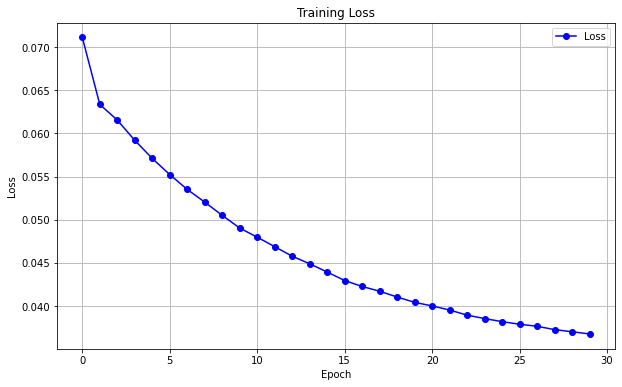

In [67]:
with open('loss_values.txt', 'r') as file:
    lines = file.readlines()
    loss_values = [float(line.strip()) for line in lines]

plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='o', color='b', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()